# **Classifying coronary artery disease using age, and blood cholesterol, and maximum heart rate.**
## **Group Report**

#### Zirun Xu, Aura Balita, and Sahil Babani

## Introduction
Coronary artery disease (CAD) is a cardiovascular condition caused by the accumulation of plaque in the coronary arteries, which are responsible for delivering blood to the heart. This plaque buildup gradually narrows the arteries, leading to reduced blood flow to the heart. CAD can lead to abnormal heart rhythms, heart attacks, and heart failure (Cleveland Clinic, n.d.). 

Four factors that increase the likelihood of heart disease are age, blood pressure, blood cholesterol levels and maximum heart rate. Individuals aged 65 and older are more likely to develop CAD due to the buildup of plaque over the years (National Institute on Aging, n.d.), while elevated blood pressure and high blood cholesterol levels are indicative of narrowed blood vessels due to plaque accumulation (Centers for Disease Control and Prevention, n.d.). Lastly, the max heart rate achieved during exercise testing is typically indicative of how well the heart is functioning. A high maximum heart rate usually means a healthier heart, while a lower one can signify a less healthy heart.).

This project aims to determine whether it is possible to predict the likelihood of an individual having heart disease based on their age, blood pressure, blood cholesterol, and maximum heart rate and to determine which variable pairs would best give the best predictions, using the Cleveland database. These variables were selected because analyzing other variables would demand a more in-depth understanding of the subject.

This database was constructed by gathering clinical test results from patients with chest pain symptoms at the Cleveland Clinic in Cleveland, Ohio database (Detrano, et al., 89).

## Methods & Results

(Explain dataset that will be used)\
(Copy and paste variables)\
(Describe the methods and approaches used to collect data)
* Explain data collection techniques
* Explain analytical techinques

### Loading the file and exploring the data
The first step is to load the `tidyverse` and `tidymodels` packages that will be used for the analysis of our data.

In [1]:
# Importing packages
library(tidyverse)
library(tidymodels)
install.packages("shiny")
library(shiny)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Our heart disease dataset is a `.csv` file with no headers. The `read_csv` function will be used to load the data, and headers will be added using the `colnames()` function. The headers come from the source. The data will then be inspected.

In [2]:
# Loading and adding headers to the heart disease data
heart_data <- read_csv("processed.cleveland.data")
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                     "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
head(heart_data)

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


### Describing the variables in the heart disease data set

Patients experiencing chest pain symptoms, also known as angina, often have a higher probability of being diagnosed with heart disease and are often recommended for coronary angiography. An angiogram involves using x-ray imaging to examine the blood vessels in a person's heart. Its purpose is to assess the condition of these vessels and the circulation of blood within them. At the Cleveland Clinic, 303 patients undergoing coronary angiography had 14 different variables measured.

The information gathered included four clinical details: age, sex, type of chest pain, and systolic blood pressure. Other tests included drawing blood to measure cholesterol levels and blood sugar, electrocardiograms, in which the electrical activity of the heart is measured, thallium scans, in which a radioactive tracer is used to see how much blood is reaching different parts of your heart, and fluoroscopy for coronary calcium, which is a procedure used to look at calcium in the heart's blood vessels.

These variables are described below:

1. **age:** age in years
2. **sex:** sex of the individual (1 = male; 0 = female)
3. **cp:** chest pain type
4. **trestbps:** resting blood pressure (in mm Hg on admission to the hospital)
5. **chol:** serum cholesterol in mg/dl
6. **fbs:** whether fasting blood sugar is greater than 120 mg/dl (1 = true; 0 = false)
7. **restecg:** resting electrocardiographic results
8. **thalach:** maximum heart rate achieved (in bpm)
9. **exang:** exercise induced angina (1 = yes; 0 = no)
10. **oldpeak:** ST depression induced by exercise relative to rest
11. **slope:** the slope of the peak exercise ST segment
12. **ca:** number of major vessels (0-3) colored by flourosopy
13. **thal:** thalassemia
14. **num:** diagnosis of heart disease (0 = not present; 1, 2, 3, 4 = present)


### Wrangling and cleaning the data
When the database was inspected with the editor, it was found that there were missing values "?" in the table. Thus, the data was cleaned and wrangled into a tidy format by converting the missing data "?" into NA values, and then removing all missing values from the dataset using the `na.omit()` function.

In [3]:
# Converting "?" in cells into "NA"
heart_data[heart_data == "?"] <- NA

# Removing missing values
heart_data <- na.omit(heart_data)
head(heart_data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3


The variable **num** indicates the diagnosis of the heart disease, with 0 meaning heart disease is not present, and 1, 2, 3, and 4 meaning that heart disease is present. However, this is too confusing. Thus, we will use `mutate()`, `as.factor()`, and `case_when()` to make things more readable. For the case that num = 0, no heart disease occurs, and the disease observation will say "No". For the case that num = 1, 2, 3, 4, heart disease is present, and the disease observation will say "Yes". 

To make things more readable, the following variables will be renamed using `colnames()`:
* **trestbps** to **rest_bp**
* **thalach** to **max_heart**
* **num** to **disease**.

As mentioned in the introduction, we will only be using age, blood pressure, blood cholesterol, maximum heart rate, and the final diagnosis for our analysis. Thus, we will create a new tibble using these five variables using `select()`. The new tibble will be renamed `heart`.

In [4]:
# Selecting and renaming column names
heart <- heart_data |>
    select(age, trestbps, chol, thalach, num)

colnames(heart) <- c("age", "rest_bp", "chol", "max_heart", "disease")

# Converting integer values to "Yes" or "No"
heart <- heart |>
    mutate(disease = as.factor(case_when(disease > 0 ~ "Yes", disease ==  0 ~ "No")))

head(heart)

age,rest_bp,chol,max_heart,disease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,160,286,108,Yes
67,120,229,129,Yes
37,130,250,187,No
41,130,204,172,No
56,120,236,178,No
62,140,268,160,Yes


### Summary of the data

The next step is to perform a summary of the dataset using `group_by()`, `summarize()`, and `n()` to find the number and percentage of disease and no disease observations in our dataset. After, the percentage in each group is found by dividing the total number of observations and multiplying by 100.

There are 137 (46%) disease observations and 159 (54%) no disease observations.

In [5]:
num_obs <- nrow(heart)
heart |>
    group_by(disease) |>
    summarize(
        count = n(),
        percentage = n() / num_obs *100
        )

disease,count,percentage
<fct>,<int>,<dbl>
No,159,53.71622
Yes,137,46.28378


### Splitting the data

(explain why it's important to split the data)

In [6]:
# Splitting the data into the training and testing sets
heart_split <- initial_split(heart, prop = 0.75, strata = disease)  

heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

head(heart_train)

age,rest_bp,chol,max_heart,disease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,130,204,172,No
56,120,236,178,No
57,120,354,163,No
56,140,294,153,No
44,120,263,173,No
52,172,199,162,No


### Summary of data

In [7]:
heart_summary <- heart_train |>
                 group_by(disease) |>
                 summarize(observations = n(), 
                           mean_age = mean(age), 
                           mean_chol = mean(chol),
                           mean_max_heart = mean(max_heart))
heart_summary

disease,observations,mean_age,mean_chol,mean_max_heart
<fct>,<int>,<dbl>,<dbl>,<dbl>
No,119,52.31092,242.1092,158.5294
Yes,102,56.51961,249.8824,138.1373


### Preliminary data visualization

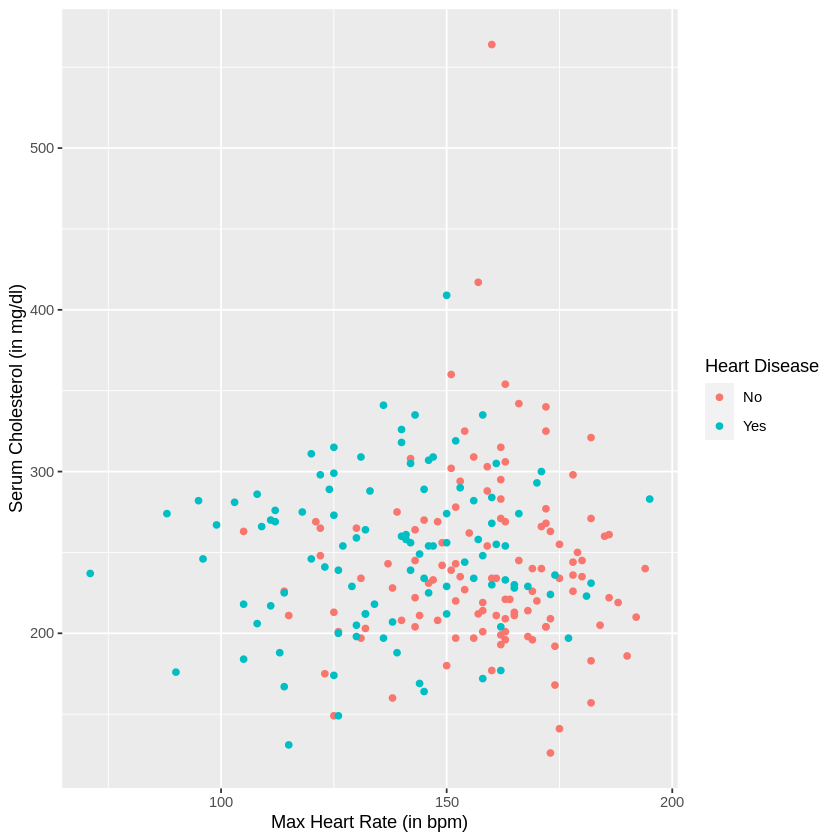

In [8]:
# create a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
# Cholesterol Levels vs. Max Heart Rate
max_heart_chol_plot <- heart_train |>
    ggplot(aes(x = max_heart, y = chol, color = disease)) +
    geom_point() +
        labs(x = "Max Heart Rate (in bpm)",
             y = "Serum Cholesterol (in mg/dl)",
             color = "Heart Disease")
max_heart_chol_plot

### Determining the most suitable $k$ value

In [9]:
# add code here

### Plotting $k$ vs Accuracy

In [10]:
# add code here

(explain which k should be used based on plot)

### Creating a $k$-NN classification model

In [11]:
# add code here

### Testing the model against another dataset

In [12]:
# add code here

## Discussion
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

## Conclusions

## References

* [Cleveland Clinic. “Coronary Artery Disease.”](my.clevelandclinic.org/health/diseases/16898-coronary-artery-disease)
* [“Coronary Artery Disease.” Centers for Disease Control and Prevention](www.cdc.gov/heartdisease/coronary_ad.htm#:~:text=To%20find%20out%20your%20risk,about%20heart%20disease%20risk%20factors.) 
* [Detrano, et al. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American journal of cardiology, 64 5, 304-10.](https://www.ajconline.org/article/0002-9149(89)90524-9/pdf)
* [“Heart Health and Aging.” National Institute on Aging, U.S. Department of Health and Human Services](https://www.nia.nih.gov/health/heart-health/heart-health-and-aging#how)

